## Read & plot S1-ETAD product via `s1reader` and `s1etad`

Reference:

+ Gisinger, C., Schubert, A., Breit, H., Garthwaite, M., Balss, U., Willberg, M., . . . Miranda, N. (2021). In-Depth Verification of Sentinel-1 and TerraSAR-X Geolocation Accuracy Using the Australian Corner Reflector Array. IEEE Transactions on Geoscience and Remote Sensing, 59(2), 1154-1181. doi:10.1109/TGRS.2019.2961248
+ `s1etad`: https://gitlab.com/s1-etad/s1-etad with Notebook examples](https://gitlab.com/s1-etad/s1-etad/-/tree/master/docs/notebooks)

In [1]:
%matplotlib inline
import datetime
import glob
import os

import numpy as np
from matplotlib import pyplot as plt, ticker

import s1reader
from s1reader import s1_etad

plt.rcParams.update({'font.size': 12})

# input files/dirs
orbit_dir = os.path.expanduser('~/data/aux/S1/aux_poeorb')
proj_dir = os.path.expanduser('~/data/opera/ChileSenAT149')
date1, date2 = '20160829', '20160922'

slc_dir = os.path.join(proj_dir, 'SLC')
eta_dir = os.path.join(proj_dir, 'ETA')

## 1. Read SLC burst object (as defined in `s1reader`)

In [2]:
fbase = os.path.join(slc_dir, f'S1*_IW_SLC__*_{date1}*')

# read SLC burst object [Sub-swath 1, burst 1 by default]
slc_file = (glob.glob(fbase+'.zip') + glob.glob(fbase + '.SAFE'))[0]
orbit_file = s1reader.get_orbit_file_from_dir(slc_file, orbit_dir, auto_download=True)
slc_burst = s1reader.load_bursts(slc_file, orbit_file, swath_num=1)[0]

## 2. Read ETA correction of one burst

Choose `corr_type` from `['sum', 'sar', 'atm', 'bistatic', 'doppler', 'fmrate', 'geodetic', 'ionospheric', 'tropospheric']`, where `geodetic` represent the solid Earth tides, and:
+ sar = bistatic + doppler + fmrate
+ atm = ionospheric + tropospheric
+ sum = sar + atm + geodetic

### 2.1 One component

Set `resample = True` to resample the low-resolution ETA correction into the same resolution as the SLC.

search ETA file with pattern: S1A_IW_ETA__*_20160829T230628_20160829T230655_012821_014394_*.SAFE
locate ETA file: /Users/yunjunz/data/opera/ChileSenAT149/ETA/S1A_IW_ETA__AXSV_20160829T230628_20160829T230655_012821_014394_F8E6.SAFE
search ETA burst in iw1 with the following time range:
start time: 2016-08-29 23:06:29.340914
end   time: 2016-08-29 23:06:32.918082
read correction data with type: bistatic
resampling the ETA correction data from ETA grid to SLC grid ...


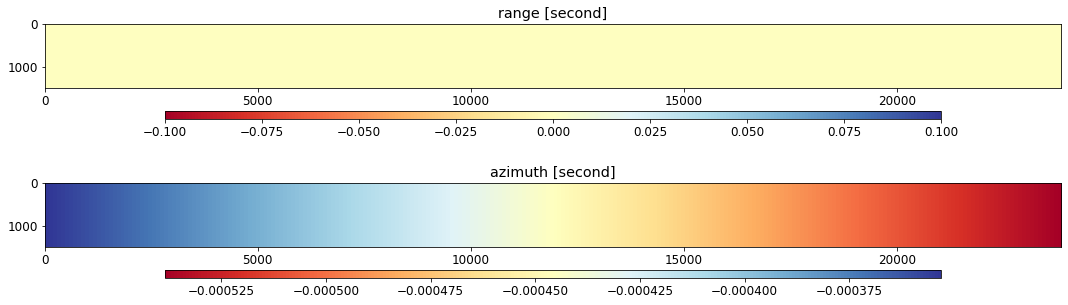

In [3]:
rg_corr, az_corr = s1_etad.get_eta_correction_from_slc_burst(
    slc_burst,
    eta_dir,
    corr_type='bistatic',
    resample=True,
    unit='second',
)

# plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[15, 5])
for ax, data, label in zip(axs, [rg_corr, az_corr], ['range', 'azimuth']):
    im = ax.imshow(data, cmap='RdYlBu', interpolation='nearest')
    fig.colorbar(im, ax=ax, orientation='horizontal', aspect=100, fraction=0.05)
    ax.set_title(f'{label} [second]')
fig.tight_layout()
plt.show()

### 2.2 All components

Set `resample = False` to use the original ETA resolution for plotting purpose.

Set `unit = meter` for a human friendly unit to get an idea of how big each component is.

In [4]:
# get ETA burst object and ETA object (as defined in `s1etad` module)
eta_burst, eta = s1_etad.get_eta_burst_from_slc_burst(slc_burst, eta_dir, verbose=True)

search ETA file with pattern: S1A_IW_ETA__*_20160829T230628_20160829T230655_012821_014394_*.SAFE
locate ETA file: /Users/yunjunz/data/opera/ChileSenAT149/ETA/S1A_IW_ETA__AXSV_20160829T230628_20160829T230655_012821_014394_F8E6.SAFE
search ETA burst in iw1 with the following time range:
start time: 2016-08-29 23:06:29.340914
end   time: 2016-08-29 23:06:32.918082


save figure to file /Users/yunjunz/data/opera/ChileSenAT149/docs/ETA_comp_20160829.png


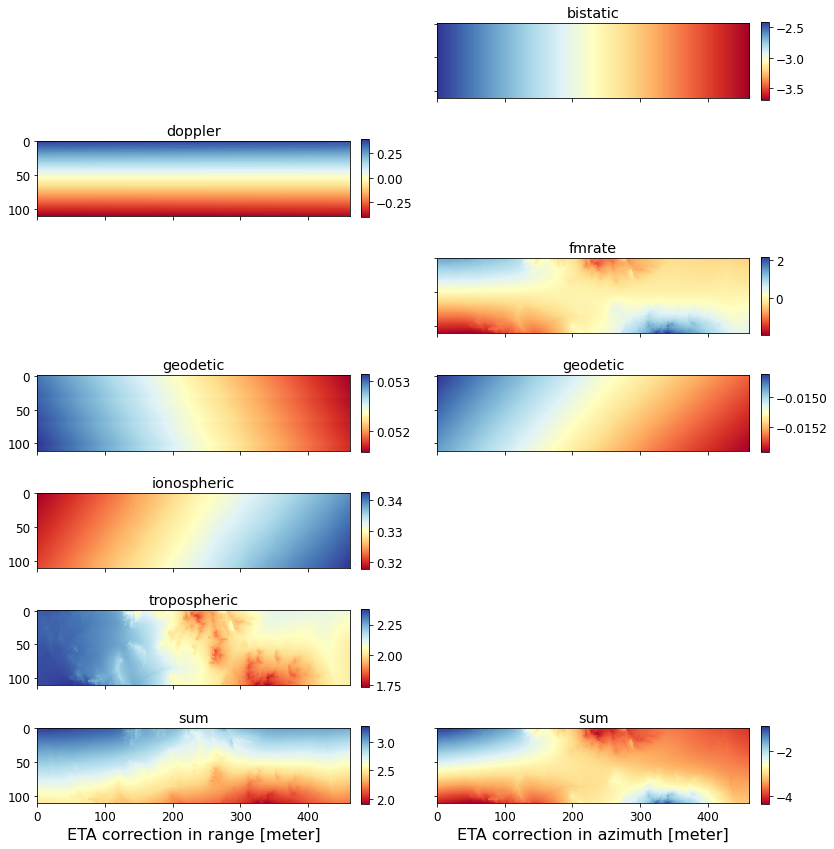

In [5]:
corr_types = ['bistatic', 'doppler', 'fmrate', 'geodetic', 'ionospheric', 'tropospheric', 'sum']
num_corr = len(corr_types)
unit = 'meter'  # meter, second, pixel

# plot
fig, axs = plt.subplots(figsize=[12, 12], nrows=num_corr, ncols=2, sharex=True, sharey=True)
for i, corr_type in enumerate(corr_types):
    # get ETA correction data
    rg_corr, az_corr = s1_etad.get_eta_correction_from_slc_burst(
        slc_burst,
        eta_dir,
        corr_type=corr_type,
        resample=False,
        unit=unit,
        verbose=False,
    )

    # plot
    for j, (corr, ax) in enumerate(zip([rg_corr, az_corr], axs[i,:])):
        if np.count_nonzero(corr) > 0:
            im = ax.imshow(corr, cmap='RdYlBu', interpolation='nearest')
            fig.colorbar(im, ax=ax, pad=0.03, shrink=0.8, aspect=10, orientation='vertical')
            ax.set_title(corr_type)
        else:
            ax.axis('off')
axs[-1,0].set_xlabel(f'ETA correction in range [{unit}]', fontsize=16)
axs[-1,1].set_xlabel(f'ETA correction in azimuth [{unit}]', fontsize=16)
fig.tight_layout()

# output
out_fig = os.path.join(proj_dir, f'docs/ETA_comp_{date1}.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## 3. Plot ETA correction mosaick

### 3.1 One SLC - Absolute

In [6]:
# check the 3 SAR processing effects only
corr_types = ['bistatic', 'doppler', 'fmrate']
corr_dirs = ['azimuth', 'range', 'azimuth']
corr_coords = ['y', 'x', 'y']

# read and mosaick via `s1etad`
corr_dict = {}
for i, corr_type in enumerate(corr_types):
    corr_dict[corr_type] = eta.merge_correction(corr_type, meter=True)[corr_coords[i]]

bistatic   - azimuth   : -3.69 / -0.01 m
doppler    - range     : -0.48 /  0.47 m
fmrate     - azimuth   : -4.05 /  3.48 m


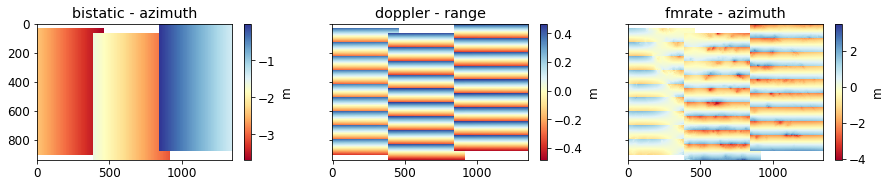

In [7]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 2.5], sharex=True, sharey=True)
for i, (ax, corr_type, corr_dir) in enumerate(zip(axs, corr_types, corr_dirs)):
    data = corr_dict[corr_type]
    im = ax.imshow(data, cmap='RdYlBu', interpolation='nearest')
    ax.set_title(f'{corr_type} - {corr_dir}')
    cbar = fig.colorbar(im, ax=ax, orientation='vertical');  cbar.set_label('m')
    print(f'{corr_type:10s} - {corr_dir:10s}: {np.nanmin(data):5.2f} / {np.nanmax(data):5.2f} m')
plt.show()

### 3.2 One pair of SLCs - Relative

In [8]:
def get_eta_obj(date_str, slc_dir, orbit_dir):
    # read SLC burst
    fbase = os.path.join(slc_dir, f'S1*_IW_SLC__*_{date_str}*')
    slc_file = (glob.glob(fbase + '.zip') + glob.glob(fbase + '.SAFE')) [0]
    orbit_file = s1reader.get_orbit_file_from_dir(slc_file, orbit_dir)
    slc_burst = s1reader.load_bursts(slc_file, orbit_file, swath_num=1)[0]

    # read ETA burst
    eta = s1_etad.get_eta_burst_from_slc_burst(slc_burst, eta_dir, verbose=True)[1]
    return eta

eta1 = get_eta_obj(date1, slc_dir, orbit_dir)
eta2 = get_eta_obj(date2, slc_dir, orbit_dir)

# have to use meter=True to account for the different spacing among bursts in the merged version
# then use the rough pixel size to convert into pixel unit [rough values for plotting purpose only]
corr_dict = {}
for i, corr_type in enumerate(corr_types):
    data2 = eta2.merge_correction(corr_type, meter=True)[corr_coords[i]]
    data1 = eta1.merge_correction(corr_type, meter=True)[corr_coords[i]]
    # handle matrix size difference
    r1 = min(data1.shape[0], data2.shape[0])
    c1 = min(data1.shape[1], data2.shape[1])
    mdata = data2[:r1, :c1] - data1[:r1, :c1]
    # mask out invalid pixels
    data = np.array(mdata.data)
    data[mdata.mask] = np.nan
    data[data == 0] = np.nan
    # save the data to dict
    corr_dict[corr_type] = data

search ETA file with pattern: S1A_IW_ETA__*_20160829T230628_20160829T230655_012821_014394_*.SAFE
locate ETA file: /Users/yunjunz/data/opera/ChileSenAT149/ETA/S1A_IW_ETA__AXSV_20160829T230628_20160829T230655_012821_014394_F8E6.SAFE
search ETA burst in iw1 with the following time range:
start time: 2016-08-29 23:06:29.340914
end   time: 2016-08-29 23:06:32.918082
search ETA file with pattern: S1A_IW_ETA__*_20160922T230629_20160922T230656_013171_014F06_*.SAFE
locate ETA file: /Users/yunjunz/data/opera/ChileSenAT149/ETA/S1A_IW_ETA__AXSV_20160922T230629_20160922T230656_013171_014F06_DB92.SAFE
search ETA burst in iw1 with the following time range:
start time: 2016-09-22 23:06:30.309854
end   time: 2016-09-22 23:06:33.887022


bistatic   - azimuth    min / max: -0.000016 / 0.000015 m
doppler    - range      min / max: -0.001061 / 0.818611 m
fmrate     - azimuth    min / max: -5.317577 / 3.230650 m


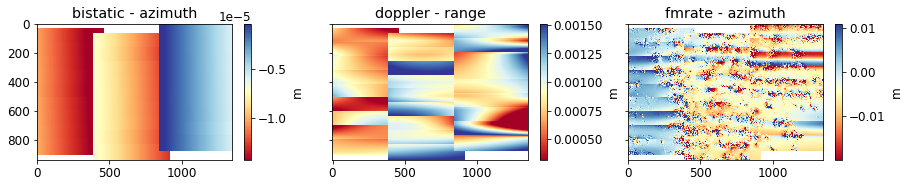

In [9]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 2.5], sharex=True, sharey=True)
for i, (ax, corr_type, corr_dir) in enumerate(zip(axs, corr_types, corr_dirs)): 
    data = corr_dict[corr_type]
    im = ax.imshow(
        data,
        vmin=np.nanpercentile(data, 2.5),
        vmax=np.nanpercentile(data, 97.5),
        cmap='RdYlBu',
        interpolation='nearest',
    )
    # axis format
    ax.set_title(f'{corr_type} - {corr_dirs[i]}')
    cbar = fig.colorbar(im, ax=ax, orientation='vertical');  cbar.set_label('m')
    print(f'{corr_type:10s} - {corr_dirs[i]:10s} min / max: {np.nanmin(data):.6f} / {np.nanmax(data):.6f} m')
plt.show()